## MobileNet Pretrained

In [1]:
import pandas as pd
import numpy as np
import pathlib
from keras.applications import MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.layers import ZeroPadding2D,Conv2D,BatchNormalization,Input,Dropout,DepthwiseConv2D,Input
from keras.layers import ReLU,GlobalAveragePooling2D,GlobalMaxPool2D,Reshape,Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import models
import os

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:



def build_keras_model():
  #Load the ResNet50 model
    shape = (1,1,int(1024*1.0))
    classes = 38
    dropout = 1e-3
    model = Sequential()
    model.add(MobileNet(weights='imagenet', 
                     include_top=False,
                     input_shape=(224, 224, 3)))
    model.add(GlobalAveragePooling2D())
    model.add(Reshape(shape,name='reshape_1'))
    model.add(Dropout(dropout,name='dropout'))
    model.add(Conv2D(classes,(1,1),padding='same',name='conv_fc'))
    model.add(Activation('softmax',name='softmax'))
    model.add(Reshape((38,),name='reshape_2'))

    model.layers[0].trainable = False
    for layer in model.layers[:5]:
        layer.trainable = True
    
    return model

In [4]:
model=build_keras_model()
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 1024)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 1024)        0         
_________________________________________________________________
conv_fc (Conv2D)             (None, 1, 1, 38)          38950     
_________________________________________________________________
softmax (Activation)         (None, 1, 1, 38)          0         
_____________________

In [5]:
def get_train_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_train_for_keras = original_data.loc[original_data['is_valid'] == False, ['relative_path', 'label']]
    df_train_for_keras = df_train_for_keras.astype(str)
    return df_train_for_keras

def get_val_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_val_for_keras = original_data.loc[original_data['is_valid'] == True, ['relative_path', 'label']]
    df_val_for_keras = df_val_for_keras.astype(str)
    return df_val_for_keras

def get_test_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_test_for_keras = original_data[['relative_path', 'label']]
    df_test_for_keras = df_test_for_keras.astype(str)
    return df_test_for_keras

df_train_for_keras = get_train_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_train_for_keras[:5])

df_val_for_keras = get_val_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_val_for_keras[:5])

df_test_for_keras = get_test_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "test_group.csv")
print(df_test_for_keras[:5])

directory = str(pathlib.Path.cwd()) + "/raw_datasets/images/plantVillage"

                                       relative_path label
0      Corn_(maize)___healthy/R.S_HL 7959 copy 2.jpg    10
1  Tomato___Spider_mites Two-spotted_spider_mite/...    33
2               Apple___Black_rot/JR_FrgE.S 8626.JPG     1
3                Tomato___healthy/GH_HL Leaf 207.JPG    37
4            Tomato___Leaf_Mold/Crnl_L.Mold 9008.JPG    31
                                           relative_path label
38070   Pepper,_bell___Bacterial_spot/JR_B.Spot 3293.JPG    18
38071        Squash___Powdery_mildew/UMD_Powd.M 0707.JPG    25
38072              Apple___Apple_scab/FREC_Scab 3120.JPG     0
38073               Grape___Black_rot/FAM_B.Rot 3107.JPG    11
38074  Tomato___Tomato_Yellow_Leaf_Curl_Virus/UF.GRC_...    35
                                       relative_path label
0  Tomato___Tomato_Yellow_Leaf_Curl_Virus/YLCV_NR...    35
1      Corn_(maize)___healthy/R.S_HL 7921 copy 2.jpg    10
2                Potato___Late_blight/RS_LB 3303.JPG    21
3            Tomato___Leaf_Mold/

In [6]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rescale=1./255,
                                   rotation_range=25,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(df_train_for_keras,
                                                    directory=directory,
                                                    x_col='relative_path',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    drop_duplicates=False)
val_generator = val_datagen.flow_from_dataframe(df_val_for_keras,
                                                directory=directory,
                                                x_col='relative_path',
                                                y_col='label',
                                                target_size=(224, 224),
                                                batch_size=64,
                                                shuffle=False,
                                                drop_duplicates=False)

Found 38070 validated image filenames belonging to 38 classes.
Found 5251 validated image filenames belonging to 38 classes.


In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

opt = optimizers.rmsprop(lr=1e-4, decay=1e-6)

# Let's train the model using RMSprop
import PIL.Image
train_model = build_keras_model()

    

#opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
train_model.compile(loss="categorical_crossentropy", optimizer="adam",
   metrics=[metrics.categorical_accuracy])

history = train_model.fit_generator(train_generator,
                          steps_per_epoch=849,
                          epochs=20,
                          validation_data=val_generator,
                          validation_steps=170)   

#model.save(str(pathlib.Path.cwd()) + "/models/" + "mobile_net_keras_stage_1_group.h5")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
849/849 [==============================] - 633s 745ms/step - loss: 0.1656 - categorical_accuracy: 0.9491 - val_loss: 0.4627 - val_categorical_accuracy: 0.8674
Epoch 2/20
849/849 [==============================] - 627s 738ms/step - loss: 0.0712 - categorical_accuracy: 0.9766 - val_loss: 0.2733 - val_categorical_accuracy: 0.9305
Epoch 3/20
849/849 [==============================] - 626s 737ms/step - loss: 0.0545 - categorical_accuracy: 0.9823 - val_loss: 0.5630 - val_categorical_accuracy: 0.8727
Epoch 4/20
849/849 [==============================] - 620s 730ms/step - loss: 0.0488 - categorical_accuracy: 0.9848 - val_loss: 0.1270 - val_categorical_accuracy: 0.9638
Epoch 5/20
849/849 [==============================] - 627s 738ms/step - loss: 0.0421 - categorical_accuracy: 0.9862 - val_loss: 0.3268 - val_categorical_accuracy: 0.9257
Epoch 6/20
849/849 [==============================] - 6

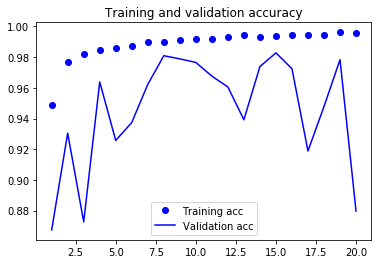

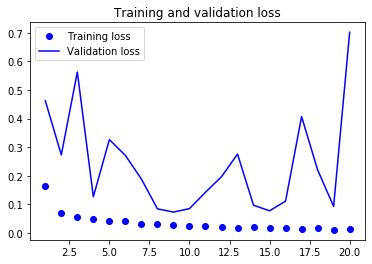

In [9]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()